This file shows how our model captures the second levelt's proposition perfectly.

In [1]:
import random
from scipy.stats import norm, stats
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import copy

In [2]:
# @title Plotting Functions
''''''

def plot_fish(fish_state, ax=None, show=True):
  """
  Plot the fish dynamics (states across time)
  """
  T = len(fish_state)

  offset = 3

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  x = np.arange(0, T, 1)
  y = offset * (fish_state*2 - 1)

  ax.plot(y, color='cornflowerblue', markersize=10, linewidth=3.0, zorder=0)
  ax.fill_between(x, y, color='cornflowerblue', alpha=.3)

  ax.set_xlabel('time')
  ax.set_ylabel('Chosen location')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-(offset+.5), offset+.5])
  ax.set_yticks([-offset, offset])
  ax.set_yticklabels(['left', 'right'])

  ax.spines['bottom'].set_position('center')
  if show:
    plt.show()


def plot_measurement(measurement, ax=None, show=True):
  """
  Plot the measurements
  """
  T = len(measurement)

  rel_pos = 3
  red_y = []
  blue_y = []
  for idx, value in enumerate(measurement):
    if value == 0:
      blue_y.append([idx, -rel_pos])
    else:
      red_y.append([idx, rel_pos])

  red_y = np.asarray(red_y)
  blue_y = np.asarray(blue_y)

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  if len(red_y) > 0:
    ax.plot(red_y[:, 0], red_y[:, 1], '*', markersize=8, color='crimson')

  if len(blue_y) > 0:
    ax.plot(blue_y[:, 0], blue_y[:, 1], '*', markersize=8, color='royalblue')

  ax.set_xlabel('time', fontsize=18)
  ax.set_ylabel('Caught fish?')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-rel_pos - .5, rel_pos + .5])
  ax.set_yticks([-rel_pos, rel_pos])
  ax.set_yticklabels(['no', 'yes!'])

  ax.spines['bottom'].set_position('center')
  if show:
    plt.show()


def plot_act_loc(loc, act, ax_loc=None, show=True):
  """
  Plot the action and location of T time points
  """
  T = len(act)

  if not ax_loc:
    fig, ax_loc = plt.subplots(1, 1, figsize=(12, 2.5))

  loc = loc*2 - 1
  act_down = []
  act_up = []
  for t in range(1, T):
    if loc[t-1] == -1 and loc[t] == 1:
      act_up.append([t - 0.5, 0])
    if loc[t-1] == 1 and loc[t] == -1:
      act_down.append([t - 0.5, 0])

  act_down = np.array(act_down)
  act_up = np.array(act_up)

  ax_loc.plot(loc, 'g.-', markersize=8, linewidth=5)

  if len(act_down) > 0:
    ax_loc.plot(act_down[:, 0], act_down[:, 1], 'rv', markersize=18, zorder=10, label='switch')

  if len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10)

  ax_loc.set_xlabel('time')
  ax_loc.set_ylabel('Your state')

  ax_loc.set_xlim([0, T])
  ax_loc.set_xticks([])
  ax_loc.xaxis.set_label_coords(1.05, .54)

  if len(act_down) > 0:
    ax_loc.legend(loc="upper right")
  elif len(act_down) == 0 and len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10, label='switch')
    ax_loc.legend(loc="upper right")

  ax_loc.set_ylim([-1.1, 1.1])
  ax_loc.set_yticks([-1, 1])

  ax_loc.tick_params(axis='both', which='major')
  ax_loc.set_yticklabels(['left', 'right'])

  ax_loc.spines['bottom'].set_position('center')

  if show:
    plt.show()


def plot_belief(belief, ax1=None, choose_policy=None, show=True):
  """
  Plot the belief dynamics of T time points
  """

  T = belief.shape[1]

  if not ax1:
      fig, ax1 = plt.subplots(1, 1, figsize=(12, 2.5))

  ax1.plot(belief[1, :], color='midnightblue', markersize=10, linewidth=3.0)

  ax1.set_xlabel('time')
  ax1.set_ylabel('Belief (right)')

  ax1.set_xlim([0, T])
  ax1.set_xticks([])
  ax1.xaxis.set_label_coords(1.05, 0.05)

  ax1.set_yticks([0, 1])
  ax1.set_ylim([0, 1.1])

  labels = [item.get_text() for item in ax1.get_yticklabels()]
  ax1.set_yticklabels(['    0', '    1'])

  """
  if choose_policy == "threshold":
    ax2 = ax1.twinx()
    ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
    ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
    ax2.set_yticks([threshold, 1 - threshold])
    ax2.set_ylim([0, 1.1])
    ax2.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = 'threshold to switch \n from left to right'
    labels[-1] = 'threshold to switch \n from right to left'
    ax2.set_yticklabels(labels)
  """
  if show:
    plt.show()


def plot_dynamics(belief, loc, act, meas, fish_state, choose_policy):
  """
  Plot the dynamics of T time points
  """
  if choose_policy == 'threshold':
    fig, [ax0, ax_bel, ax_loc, ax1] = plt.subplots(4, 1, figsize=(12, 9))
    plot_fish(fish_state, ax=ax0, show=False)
    plot_belief(belief, ax1=ax_bel, show=False)
    plot_measurement(meas, ax=ax1, show=False)
    plot_act_loc(loc, act, ax_loc=ax_loc)
  else:
    fig, [ax0, ax_bel, ax1] = plt.subplots(3, 1, figsize=(12, 7))
    plot_fish(fish_state, ax=ax0, show=False)
    plot_belief(belief, ax1=ax_bel, show=False)
    plot_measurement(meas, ax=ax1, show=False)

  plt.tight_layout()
  plt.show()


def belief_histogram(belief, bins=100):
  """
  Plot the histogram of belief states
  """
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.hist(belief, bins)
  ax.set_xlabel('belief', fontsize=18)
  ax.set_ylabel('count', fontsize=18)
  plt.show()


def plot_value_threshold(threshold_array, value_array):
  """
  Helper function to plot the value function and threshold
  """
  yrange = np.max(value_array) - np.min(value_array)
  star_loc = np.argmax(value_array)

  fig_, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.plot(threshold_array, value_array, 'b')
  ax.vlines(threshold_array[star_loc],
            min(value_array) - yrange * .1, max(value_array),
            colors='red', ls='--')
  ax.plot(threshold_array[star_loc],
          value_array[star_loc],
          '*', color='crimson',
          markersize=20)

  ax.set_ylim([np.min(value_array) - yrange * .1,
               np.max(value_array) + yrange * .1])
  ax.set_title(f'threshold vs value with switching cost c = {cost_sw:.2f}',
               fontsize=20)
  ax.set_xlabel('threshold', fontsize=16)
  ax.set_ylabel('value', fontsize=16)
  plt.show()

In [3]:
class MDP:

    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [page 646]"""

    def __init__(self, init, actlist, terminals, transitions = {}, reward = None, states=None, gamma=.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        if states:
            self.states = states
        else:
            ## collect states from transitions table
            self.states = self.get_states_from_transitions(transitions)
            
        
        self.init = init
        
        if isinstance(actlist, list):
            ## if actlist is a list, all states have the same actions
            self.actlist = actlist
        elif isinstance(actlist, dict):
            ## if actlist is a dict, different actions for each state
            self.actlist = actlist
        
        self.terminals = terminals
        self.transitions = transitions
        if self.transitions == {}:
            print("Warning: Transition table is empty.")
        self.gamma = gamma
        if reward:
            self.reward = reward
        else:
            self.reward = {s : 0 for s in self.states}
        #self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""
        if(self.transitions == {}):
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Set of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set([tr[1] for actions in transitions.values() 
                              for effects in actions.values() for tr in effects])
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):
        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)
        # check that init is a valid state
        assert self.init in self.states
        # check reward for each state
        #assert set(self.reward.keys()) == set(self.states)
        assert set(self.reward.keys()) == set(self.states)
        # check that all terminals are valid states
        assert all([t in self.states for t in self.terminals])
        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

In [4]:
class POMDP(MDP):


    def __init__(self, actions, transitions=None, rewards=None, states=None, p_stay = 0.95, sigmaAttention = np.array([.1, .02]), gamma=0.95, x = 2, y = 2, Initial_loc = 0):
        """Initialize variables of the pomdp"""
        # States: 0: Pinwheel, 1: Bull's-eye horizontal, 2: Bull's-eye vertical
        # Actions: 0: Pinwheel Perception, 1: Bull's-eye horizontal Perception, 2: Bull's-eye vertical Perception, 3: Key Bull's-eye horizontal, 4: Key Bull's-eye vertical
        # x is number of actions, and y is number of states
        if not (0 <= gamma <= 1):
            raise ValueError('A POMDP must have 0 < gamma <= 1')
        #p_stay and sigma attention are related to updating the belief 
        self.p_stay = p_stay
        self.sigmaAttention = sigmaAttention
        self.states = states
        self.actions = actions
        self.rewards = rewards
        # self.t_prob = np.array([[self.p_stay, (1-self.p_stay)/2, (1-self.p_stay)/2],
        #                          [(1-self.p_stay)/2, self.p_stay, (1-self.p_stay)/2],
        #                            [(1-self.p_stay)/2, (1-self.p_stay)/2, self.p_stay]])
        self.t_prob = transitions
        # transition model cannot be undefined
        # transitions = p_stay
        
        #t_prob is (2,2,2) 3d matrix. First dimension determines the action choice. Second dimension determines the state which the agent was in.
        # if not isinstance(transitions, (np.ndarray, list)):
        #     self.t_prob = np.array([[[transitions, 1-transitions] for _ in range(x)] for _ in range(y)], dtype=float)
        # else:
        #     self.t_prob = transitions

        # """if not self.t_prob:
        # print('Warning: Transition model is undefined')"""

        '''# sensor model cannot be undefined
        # self.e_prob = evidences or {}
        # if not self.e_prob:
        #     print('Warning: Sensor model is undefined')'''

        self.gamma = gamma
    
        #prev_state determines the previous action
        self.prev_state = Initial_loc
        # history is a number that determines the number of same actions which are chosen consequently
        self.history = 1
        # These lists are defined to save previous variants
        self.actlist = []
        self.statelist = []
        self.belieflist = []
        self.rewardlist = [[] for i in range (y)]
        # Initial reward (It is randomy assigned)
        # The dimensions of the reward array determine from which state the agent goes to which state
        self.reward_arr = np.full((x,y),1,dtype=float)
        self.fu_reward_arr = np.full((x,y),2,dtype=float)
        self.max_fu_reward = np.full((y),2,dtype=float)
        
        self.e_prob = np.random.dirichlet(np.ones(y))
        self.belief = np.random.dirichlet(np.ones(y))
        # print(self.t_prob)
    # chooses the actions based on the maximum utility of the previous state 
    def selected_action(self, utility : list):
        # exp_utilities = np.exp(utility)
        # probabilities = exp_utilities / np.sum(exp_utilities)
        # return np.random.choice(len(utility), p=probabilities)
        act = np.argmax(utility)
        return act
    
    def outcome(self, utility):
        # outcome_0 = np.sum(utility[0]*self.t_prob[0][int(self.prev_state)])
        # outcome_1 = np.sum(utility[1]*self.t_prob[1][int(self.prev_state)])
        outcome = np.zeros(len(self.actions), dtype= float)
        for i in range(len(utility)):
            outcome[i] = np.sum(utility[i])
        return outcome
    
    # Based on the chosen action and transition probabilities, it determines which state would be the next one which the agent will be placed
    def last_state(self, action):
        return str(action)
    
    # updates the reward, it generates a (2,2) array (more explanation in reward_arr initialization)
    def reward_set (self):

        """
            rewards = (rewDom, c1, c2, alpha , expts, key_rew, fixrewardstep)
            rewards = (1,                   1,                  10,     2,      5)"""
        rewDom, rewDom2, c1 , expts, consfixed = self.rewards
        exp_decay = 10 * np.exp(-self.history/expts)
        # rewsupp = 10 * np.exp(-5/expts)
        rewsupp = 10


        if self.prev_state == '0':

            self.reward_arr[1,1] = rewsupp * rewDom2 / 10
            self.reward_arr[0,0] = exp_decay*rewDom/10
            self.reward_arr[1,0]= c1
            self.reward_arr[0,1] = c1 

        elif self.prev_state == '1':

            self.reward_arr[0,0] = rewsupp *rewDom/10
            self.reward_arr[1,1] = exp_decay* rewDom2 / 10
            self.reward_arr[1,0]= c1
            self.reward_arr[0,1] = c1 




    def belief_update(self):
        # opp_state = np.abs(1-prev_state)
        # state = int(self.prev_state)

        # evaluatuing belief_0
        # print('pp', type(self.prev_state)).
        # print(self.sigmaAttention)
        if self.prev_state == '0':

            sigma1 = self.sigmaAttention[0] 
            sigma2 = self.sigmaAttention[1]


        elif self.prev_state == '1': 

            sigma1 = self.sigmaAttention[1] 
            sigma2 = self.sigmaAttention[0]

  
        
        mu = 0
        obsVal = np.random.normal(mu, sigma1, 1)
        obsProb0 = norm.pdf(obsVal, loc=mu, scale=sigma1)

        mu = 1
        obsVal = np.random.normal(mu, sigma2, 1)
        obsProb1 = norm.pdf(obsVal, loc=mu, scale=sigma2)



        observation_array = np.concatenate((obsProb0, obsProb1))
        # print('observation_array', observation_array)
        belief_arr = np.multiply(np.matmul(np.transpose(self.t_prob), np.transpose(self.belief)), observation_array)

        self.belief = belief_arr/np.sum(belief_arr)
        self.belieflist.append(belief_arr[0])







    
    #at the end of each point, updates the variants
    def update(self, st, action):
        # for i in range(len(self.rewardlist)):
        #     self.rewardlist[i].append(self.reward_arr[self.prev_state,i])
        if st != '0':
            if self.prev_state != '0':
                self.history += 1
            else:
                self.history = 0
        else:
            if self.prev_state == '0':
                self.history += 1
            else:
                self.history = 0
                
        self.prev_state = st
        self.actlist.append(action)
        self.statelist.append(st)


        

    def remove_dominated_plans(self, input_values):
        """
        Remove dominated plans.
        This method finds all the lines contributing to the
        upper surface and removes those which don't.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = [values[0]]
        y1_max = max(val[1] for val in values)
        tgt = values[0]
        prev_b = 0
        prev_ix = 0
        while tgt[1] != y1_max:
            min_b = 1
            min_ix = 0
            for i in range(prev_ix + 1, len(values)):
                if values[i][0] - tgt[0] + tgt[1] - values[i][1] != 0:
                    trans_b = (values[i][0] - tgt[0]) / (values[i][0] - tgt[0] + tgt[1] - values[i][1])
                    if 0 <= trans_b <= 1 and trans_b > prev_b and trans_b < min_b:
                        min_b = trans_b
                        min_ix = i
            prev_b = min_b
            prev_ix = min_ix
            tgt = values[min_ix]
            best.append(tgt)

        return self.generate_mapping(best, input_values)

    def remove_dominated_plans_fast(self, input_values):
        """
        Remove dominated plans using approximations.
        Resamples the upper boundary at intervals of 100 and
        finds the maximum values at these points.
        """

        values = [val for action in input_values for val in input_values[action]]
        values.sort(key=lambda x: x[0], reverse=True)

        best = []
        sr = 100
        for i in range(sr + 1):
            x = i / float(sr)
            maximum = (values[0][1] - values[0][0]) * x + values[0][0]
            tgt = values[0]
            for value in values:
                val = (value[1] - value[0]) * x + value[0]
                if val > maximum:
                    maximum = val
                    tgt = value
            
            if all(any(tgt != v) for v in best):
                best.append(np.array(tgt))

        return self.generate_mapping(best, input_values)

    def generate_mapping(self, best, input_values):
        """Generate mappings after removing dominated plans"""

        mapping = defaultdict(list)
        # print('best: ',best)
        # print('input: ',input_values)
        for value in best:
            for action in input_values:
                if any(all(value == v) for v in input_values[action]):
                    mapping[action].append(value)
        # print(mapping)
        return mapping

    def max_difference(self, U1, U2):
        """Find maximum difference between two utility mappings"""

        for k, v in U1.items():
            sum1 = 0
            for element in U1[k]:
                sum1 += sum(element)
            sum2 = 0
            for element in U2[k]:
                sum2 += sum(element)
        return abs(sum1 - sum2)
    

    def belief_generation(self):
        
        states = [i for i in self.states]
        observation = [[] for i in self.states]

        for i in states:
            if i == '0':

                sigma1 = self.sigmaAttention[0] 
                sigma2 = self.sigmaAttention[1]


            elif i == '1': 

                sigma1 = self.sigmaAttention[1] 
                sigma2 = self.sigmaAttention[0]
 
            
            mu = 0
            obsVal = np.random.normal(mu, sigma1, 1)
            obsProb0 = norm.pdf(obsVal, loc=mu, scale=sigma1)

            mu = 1
            obsVal = np.random.normal(mu, sigma2, 1)
            obsProb1 = norm.pdf(obsVal, loc=mu, scale=sigma2)


            observation_array = np.concatenate((obsProb0, obsProb1))

            observation[int(i)] = observation_array/np.sum(observation_array)

        self.e_prob = observation
    
    def future_reward(self, future_step, dic):
                
        ff = future_step

        history = self.history
        state = self.statelist[-1]

        for x in range(1,ff):
            seq_list = []
            for i in range(2**x):

                binary_number = f'{i:0{x}b}'  # Convert to binary and pad with leading zeros to ensure 10 digits
                seq_list.append(binary_number)
            # print(seq_list)
            rew = None


            for seq in seq_list:
                hist = history
                current_node = dic
                prev_state = state
                # print('hist: ', hist)
                for j in range(len(seq)):
                    current_node = current_node[seq[j]]
                    if seq[j] == str(prev_state):
                        hist += 1
                        prev_state = seq[j]
                    elif seq[j] != str(prev_state):
                        hist = 0
                        prev_state = seq[j]
                # print('Seq: ', seq)
                self.reward_generation(hist, int(prev_state))
                # rew = copy.deepcopy(self.fu_reward_arr)
                rew = copy.deepcopy(self.fu_reward_arr)
                # rew = copy.deepcopy(self.reward_arr)
                # print('Att reward: ', rew)
                current_node['r'] = rew
                # print('current_node[r]: ',current_node['r'])
                # print('DDDIIIII: ', dic)
        dic['r'] = copy.deepcopy(self.reward_arr)
        return dic


            
            
            

In [5]:
def utility_calculation(pomdp, future_step, epsilon=0.1):
    """Solving a POMDP by value iteration."""
    
    U = {'':[[0]* len(pomdp.states)]}
    count = 0
    while True:
        count += 1
        prev_U = U
        # print('iteratation: ')
        values = [val for action in U for val in U[action]]
        rewards = pomdp.reward_arr
        pomdp.belief_generation()
        # print('e_prob ', pomdp.e_prob)
        # print('val is: ',values , '\n')
        value_matxs = []

        for i in values:
            for j in values:
                value_matxs.append([i, j])
        # print('matrix is : ', value_matxs)
        U1 = defaultdict(list)
        # print('U1 defaults ', U1)
        for u in value_matxs:
            for action in pomdp.actions:
                # print(u)
                utility = np.matmul(np.matmul(pomdp.t_prob, np.multiply(pomdp.gamma, np.multiply(pomdp.e_prob, np.transpose(u)))),[[1],[1]])
                rew = np.matmul(np.multiply(np.tile([rewards[int(action)]], (2, 1)).T,pomdp.t_prob),[[1],[1]])
                u1 = np.add(utility, rew)
                # print('u: ', u,'\n')
                # print('e: ', belief,'\n')
                # print('next_step', next_step_utility,'\n')

                # print('action: ', action)
                
                # print('rew', np.transpose([rew[int(action)]]))
                # print('current:', current_utility)
                # print('t_prob', pomdp.t_prob)
                # u1 = np.matmul(pomdp.t_prob, current_utility)
                # print('reward is: ', [rewards[int(action)]],'\n')
                # print('little u1 is: ',u1 ,'\n')
                u1 = np.transpose(u1)
                U1[action].append(u1[0])
                # print('U1 all possible: ', U1,'\n')
                


        U = pomdp.remove_dominated_plans_fast(U1)
        # print('U1', U1,'\n')
        
        
        # U = U1
        # print('U final', U)
        # print(2*'\n')
        # replace with U = pomdp.remove_dominated_plans(U1) for accurate calculations

        if count > future_step:
            
            # if pomdp.max_difference(U, prev_U) < epsilon * (1 - pomdp.gamma) / pomdp.gamma:
            for act in pomdp.actions:
                if act not in U:
                    max =np.sum(pomdp.belief * U1[act][0])
                    arg = 0
                    for j in range(1, len(U1[act])):
                        # print(f'{j}: ', rewardfu[i][j])
                        # print(f'{j}*e: ',np.sum(pomdp.e_prob * rewardfu[i][j]))
                        now = np.sum(pomdp.belief * U1[act][j])
                        if now > max:
                            # print('Now')
                            max = now
                            arg = j
                    U[act] = [U1[act][arg]]
                #     U[i] = [np.array(rewards[int(i)])]
            # print('UUUUUU: ',U)

            U = [U[i] for i in pomdp.actions]
            return U

In [6]:
def test_pomdp_value_iteration(actions, rewards, transitions, states, p_stay, sigmaAttention, gamma, future_steps, iterations, switching_cost, Initial_loc,counter):


    pomdp = POMDP(actions = actions, rewards = rewards, transitions=transitions, states = states, p_stay=p_stay, sigmaAttention = sigmaAttention, gamma = gamma, Initial_loc=Initial_loc)
    utility, actlist = pomdp_value_iteration(pomdp, future_steps, iterations, switching_cost, counter = counter)
    
    return utility, actlist

In [7]:
def pomdp_value_iteration(pomdp, future_steps, iterations = 500, switching_cost = 2,  epsilon=0.1, Initial_loc=0,counter = 5000):
    """Solving a POMDP by value iteration."""

    pomdp.update(Initial_loc,Initial_loc)
    # U = {'': [[0] * len(pomdp.states)]}
    switching_cost = switching_cost
    count = 0
    future_step = future_steps
    # Variables below are used for plotting and storing times which agent spends between two switches
    c0 = 1
    c1 = 1

    prev = Initial_loc
    duration = [[] for i in range(2)]
    all_states_duration = [[] for i in range(len(pomdp.states))]
    ulist = [[] for i in range(len(pomdp.states))]
    max_count = iterations
    while True:
        count += 1
        # print('\n','\n','\n','\n','\n')
        
        # 
        #adding a cost for switching the states
        # if count%counter == 0:
        #     print(count)
        # print(count)

        rewardfu = utility_calculation(pomdp, future_step)
        
        # print('Rewardddddd. ', pomdp.reward_arr)
        # print('rewardfu: ',rewardfu)
        
        # print('HEEEEEEEEEEEREEEEEEEEEE')
        # print('\n')
        # print('rewardfu: ', rewardfu)
        # print('EEE: ', pomdp.e_prob)
        
        cost_added = np.zeros((len(pomdp.actions), len(pomdp.states)), dtype=float)
        # print('costadded: ',cost_added)
        for i in range(len(rewardfu)):
            # print('1: ', rewardfu[i][0])
            # print('1*e: ',np.sum(pomdp.e_prob * rewardfu[i][0]))
            max =np.sum(pomdp.belief * rewardfu[i][0])
            arg = 0
            for j in range(1, len(rewardfu[i])):
                # print(f'{j}: ', rewardfu[i][j])
                # print(f'{j}*e: ',np.sum(pomdp.e_prob * rewardfu[i][j]))
                now = np.sum(pomdp.belief * rewardfu[i][j])
                if now > max:
                    # print('Now')
                    max = now
                    arg = j
            cost_added[i] = rewardfu[i][arg]
        # if pomdp.statelist[-1] == 0:
        #     cost_added = rewardfu  
        # else: 
        #     cost_added = rewardfu 
            
        # print('costadded: ',cost_added)
        # print('\n')
        # print(count)
        # print('1. ', pomdp.reward_arr)
        # print('2. ' ,pomdp.fu_reward_arr)
        # print('3. ', pomdp.max_fu_reward)
        # print('cost added. ', cost_added)   
        # cost_added = pomdp.reward_arr + np.array([[0,switching_cost],[0,switching_cost]])
        # hypo_belief = pomdp.belief_generation()
        # possible_outcome = rewardfu * hypo_belief
        
        
        # print('possible outcome: ', future_outcome)
        # if pomdp.statelist[-1] == 0:
        #     # cost_added = future_outcome + pomdp.reward_arr +  np.array([[switching_cost,0],[switching_cost,0]])
        #     cost_added = future_outcome + pomdp.reward_arr
        # else: 
        #     # cost_added = future_outcome + pomdp.reward_arr +  np.array([[0,switching_cost],[0,switching_cost]])
        #     cost_added = future_outcome + pomdp.reward_arr
        
        # print('cost added: ', cost_added)
        # cost_added = rewardfu
        # print('belief ',pomdp.belief)
        U = pomdp.belief * cost_added
        # print('U: ', U)
        
        # print(possible_outcome)
        

        
        # print('e ',pomdp.belief)
        # print('r ', pomdp.reward_arr)
        # print('U ',U)
        

        # determines the more valued action for both states (for example, if the agent was in the state 0, which action would be more valued. and vice versa)
        # print(action)
        
        outcome = pomdp.outcome(U)
        # print('o: ', outcome)
        
        if prev == '0':
            outcome = outcome - np.array([0,switching_cost])
        elif prev == '1':
            outcome = outcome - np.array([switching_cost,0])

        # print('outcome: ', outcome)
        # now we select action based on the previous state,
        act = pomdp.selected_action(outcome)
        # print('action: ', act)
        state = pomdp.last_state(act)
        #storing times which agent spends between two switches

        
        if prev == state:
            if state == '0':
                c0 += 1
                # c1 = 1
            elif state == '1':
                c1 += 1
                # c0 = 1
        elif prev != state:
            if prev == '0':
                duration[0].append(c0)
                c0 = 1
            elif prev == '1':
                duration[1].append(c1)
                c1 = 1

        prev = state
        # print(prev)
        # sacing values in each time point
        ulist[0].append(outcome[0])
        ulist[1].append(outcome[1])
        # print(act)

        # choosing the next state baseed on the action and transition probabilities
        # print('\n','\n')

        # updates for the next time point 

        # print('count', count)
        # print('Rewardddddd. ', pomdp.reward_arr)
        # print('rewardfu: ',rewardfu)
        # print('belief ',pomdp.belief)
        # print('U: ', U)
        # print('o: ', outcome)
        # print('action: ', act)
        # print('state: ', state,'\n')
        
        pomdp.update(state,act)
        pomdp.belief_update()
        pomdp.reward_set()

        if count > max_count:

            if prev == '0':
                duration[0].append(c0)
            elif prev == '1':
                duration[1].append(c1)
            
            return duration, pomdp.actlist
            

In [8]:
# for i in range(1):
#     time = test_pomdp_value_iteration()

In [9]:
# tim = [[],[]]
# time = test_pomdp_value_iteration()
# tim[0].extend(time[0])
# tim[1].extend(time[1])

In [10]:
def rivalry_dynamics(rewdom,rewdom2,c1, obs_noise, p_stay, gamma, future_steps, switching_cost):
    # rewards = (rewDom, c1 , expts, consfixedd)
    rewards = (rewdom, rewdom2, c1, 5,  0)
    # def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95)
    sigmaAttention = obs_noise
    p_stay = p_stay
    gamma = gamma

    transitions = np.array([[p_stay, 1-p_stay],
                                [1-p_stay, p_stay]])
    # print('transitions', transitions)
    actions = ('0', '1')
    states = ('0', '1')
    Initial_loc = 0


    future_steps = future_steps
    iterations = 5000
    counter = 6000
    switching_cost = switching_cost
    time, actlist  = test_pomdp_value_iteration(actions, rewards, transitions, states, p_stay, sigmaAttention, gamma, future_steps, iterations, switching_cost, Initial_loc,counter)



    # side = {0: 'Left', 1: 'Right'}

    # fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # for j in range(2):
    #     data = time[j]

    #     axs[j].hist(data, bins=250, alpha=0.7, label='Histogram')

    #     mean = np.mean(data)
    #     std = np.std(data)

    #     # Add mean and standard deviation to the legend
    #     axs[j].legend([f"Mean: {mean:.2f}, SD: {std:.2f}"], loc='upper right')

    #     axs[j].set_xlabel("Time Duration")
    #     axs[j].set_ylabel("Frequency" if j == 0 else "")
    #     axs[j].set_title(f'{side[j]} Histogram')

    #     ks_statistic, p_value = stats.kstest(data, 'gamma', args=(2,))
    #     print(f"KS Test: {ks_statistic}, p-value: {p_value}")

    # plt.tight_layout()
    # plt.show()

    total_time = [sum(state_time) for state_time in time]

    total_sum = sum(total_time)
    proportions = [t / total_sum for t in total_time]

    # states = ['Left Eye', "Right Eye"]

    # plt.figure(figsize=(10, 6))
    # bars = plt.bar(states, proportions, color=['red', 'blue'])

    # for bar in bars:
    #     height = bar.get_height()
    #     plt.text(bar.get_x() + bar.get_width()/2., height,
    #             f'{height:.2%}',
    #             ha='center', va='bottom')

    # plt.title('Proportion of Time Spent in Each State')
    # plt.ylabel('Proportion of Total Time')
    # plt.ylim(0, 1) 

    # plt.grid(axis='y', linestyle='--', alpha=0.7)

    # plt.savefig('state_proportions.png')
    # plt.show()

    return proportions



In [11]:
duration = {}
predomlist = []

In [12]:
duration

{}

## Proposition 2
#### Increasing the difference in stimulus strength between the two eyes will primarily act to increase the average perceptual dominance duration of the stronger stimulus (Brascamp & Klink. 2015).

In [15]:
def rivalry_dynamics(rewdom, rewdom2, c1, obs_noise, p_stay, gamma, future_steps, switching_cost):
    # rewards = (rewDom, c1 , expts, consfixedd)
    rewards = (rewdom,rewdom2, c1, 5,  0)
    # def __init__(self, actions, transitions=None, evidences=None, rewards=None, states=None, gamma=0.95)
    sigmaAttention = obs_noise
    p_stay = p_stay
    gamma = gamma

    transitions = np.array([[p_stay, 1-p_stay],
                                [1-p_stay, p_stay]])
    # print('transitions', transitions)
    actions = ('0', '1')
    states = ('0', '1')
    Initial_loc = 0


    future_steps = future_steps
    iterations = 5000
    counter = 6000
    switching_cost = switching_cost
    time, actlist  = test_pomdp_value_iteration(actions, rewards, transitions, states, p_stay, sigmaAttention, gamma, future_steps, iterations, switching_cost, Initial_loc,counter)


    total_time = [np.mean(state_time) for state_time in time]

    # total_sum = sum(total_time)
    # proportions = [t / total_sum for t in total_time]

    return total_time



In [16]:
duration2 = {}


In [17]:
Strength = 50
meanlist = [[],[]]
# x = [10,200]
a = [10, 60, 110, 160,  210]
for i in a:
    print(i)
    for j in a:
    
        rewdom, rewdom2, c1,  obs_noise, p_stay, gamma, future_steps, switching_cost = i, j, -3, np.array([0.02, 0.1]), 0.65, 0, 0, 3
        output1= rivalry_dynamics(rewdom,rewdom2,  c1,  obs_noise, p_stay, gamma, future_steps, switching_cost)
        duration2[i] = output1
        # print(output1,output2)
        meanlist[0].append(np.array([i,j,output1[0]]))
        meanlist[1].append(np.array([i,j,output1[1]]))

10
60
110
160
210


In [20]:
meanlist

[[array([10.        , 10.        , 24.46078431]),
  array([10.        , 60.        ,  4.33076923]),
  array([ 10.        , 110.        ,   1.51369863]),
  array([ 10.        , 160.        ,   1.25899281]),
  array([ 10.        , 210.        ,   1.16058394]),
  array([60.        , 10.        , 29.67567568]),
  array([60.   , 60.   ,  9.648]),
  array([ 60.        , 110.        ,   6.20727273]),
  array([ 60.        , 160.        ,   5.04247104]),
  array([ 60.        , 210.        ,   3.58646617]),
  array([110.        ,  10.        ,  33.56737589]),
  array([110.        ,  60.        ,  12.01865672]),
  array([110.        , 110.        ,   8.54642857]),
  array([110.        , 160.        ,   7.12367491]),
  array([110.       , 210.       ,   5.8989547]),
  array([160.        ,  10.        ,  36.66666667]),
  array([160.        ,  60.        ,  13.56877323]),
  array([160.        , 110.        ,  10.53380783]),
  array([160.        , 160.        ,   8.42320819]),
  array([160.        , 

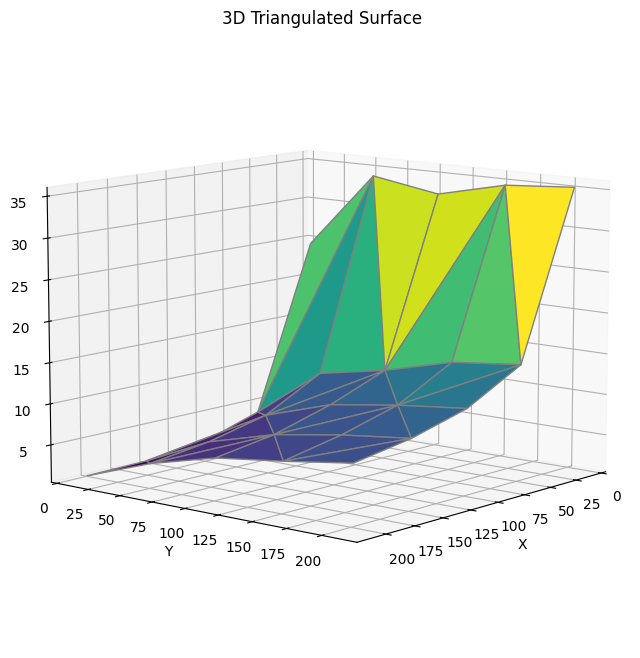

In [21]:
# Extract x, y, z coordinates
a = np.array(meanlist)
i = 1
x = a[i][:, 0]
y = a[i][:, 1]
z = a[i][:, 2]

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Triangulated surface plot
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='gray')

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Triangulated Surface')
ax.view_init(elev=10, azim=40)
plt.show()

In [33]:
# import plotly.graph_objects as go
# import numpy as np
# from scipy.spatial import Delaunay

# # Assuming meanlist is your data (adapt as needed)
# a = np.array(meanlist)
# i = 0  # Select the desired index
# x = a[i][:, 0]
# y = a[i][:, 1]
# z = a[i][:, 2]

# # Perform Delaunay triangulation (same as Matplotlib's trisurf)
# tri = Delaunay(np.column_stack((x, y)))

# # Create mesh plot
# fig = go.Figure(data=[
#     go.Mesh3d(
#         x=x, y=y, z=z,
#         i=tri.simplices[:, 0],
#         j=tri.simplices[:, 1],
#         k=tri.simplices[:, 2],
#         intensity=z,  # Color by Z-value
#         colorscale='Viridis',
#         opacity=0.8,
#         flatshading=True,
#         lighting=dict(
#             ambient=0.2,
#             diffuse=0.8,
#             roughness=0.9
#         )
#     )
# ])

# # Customize layout
# fig.update_layout(
#     title='3D Triangulated Surface (Plotly)',
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z',
#         camera=dict(eye=dict(x=1.5, y=1.5, z=0.5))  # Initial view angle
#     ),
#     margin=dict(l=0, r=0, b=0, t=30)
# )

# # Show plot (use renderer="vscode" if in VS Code with Plotly extension)
# fig.show()

Based on the figure 3B of Brascamp and Klink (2015). The model can well replicate the observers' perceptual behavior in binocular rivalry.